# Do Seattle Home Prices Factor in the Value of Local Business Venues?

 ## **1. The Question**

I have been researching home prices recently and have found myself often looking for address on Google Maps to see what is nearby.  The nearby public venues, such as parks, coffee shops, or nail salons, factor into how much I'm willing to pay for a house.  Has this been factored into the housing market?

Individuals or families who are doing market research to sell their house can use my results to help them factor in the value of nearby public venues.  My model will give an idea of which types, or categories, of venues contribute positively, which contribute negatively, and relatively how much.  Sellers can use this information to more accurately price their homes to the market.

In [26]:
# First we import the libraries we will be using.
import types
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import requests
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# 2. The Data

* First we download the two tables we will be using.  They are publicly available from  https://data.kingcounty.gov/.  King County provides quite a lot of data, including demographic, tax, and other information about the county in several different formats.  However, I found some of the data was incomplete, or needed some cleaning.

* The first table is our sales data.  The table is called "EXTR_RPSale.csv." This is a table of real estate parcel sales in King County over the last 60 years or so.  We are only interested in a small portion of this huge table.  We will just extract residental property sales over the last 5 years.

* The second is detailed information about residential land parcels in King Country, called "EXTR_ResBldg.csv."  This table has quite a lot of features and we will be selective about how we choose the ones we want our model to use.

* Next we will use the Google Geocoder API to turn our address information from the parcel data into Longitude and Latitude features.

* Finally, we will use the Foursquare API to look up the 10 closest venues to each home sale within 1km and put that into a One-Hot format that is friendly for regression modeling.

**In the end, we will have a table with location, sales, and nearby venues for thousands of residential home sales near Seattle during the last five years.  Specifically our dataset will cover homes sold for between / 100,000 and 2 million dollars, with one building and one living unit.  This will make it most relevant to the home sellers I want to help.**

## Features
### *The features we will end up with after feature selection*

* **PIN** is Parcel Identification Number, our unique index of land parcels.

* **SalePrice** is how much the parcel last sold for, between 100,000 and 2,000,000.

* **SqFt* Features** are variables for how big different parts of the home and parcel are.

* **DaylightBasement** is a boolean of whether the basement gets light.

* **Brickstone** is the percentage of the building made of brick or stone.

* **Bedrooms** is the number of bedrooms.

* **Bath* Features** are counts of different kinds of bathrooms.

* **YrBuild** is the year the building was built.

* **Latitude** and Longitude show the location of the land parcel.

* **Venue categorys** (Park, Ethopian Restaurant, Convenience Store, etc) columns are a count of how many of that venue category are among the 10 closest within 100km for each sample.

* **HeatSystem** is the kind of heating system.

* **BldgGrade** and **FinBasementGrade** are the quality of construction of the building and it's finished basement.  

* **Condition** is the current condition of the property (at the most recent assessment).

# Decode tables for HeatSystem, BldgGrade, FinBasementGrade, and condition

|**HeatSystem**| **BldgGrade and FinBasementGrade** | **Condition**
|:-----------|:-----:|:---
|0	Unknown| | 
|1	Electric| 3 Poor | 1 Poor|
|2	Electric wall| 4 Low	| 2 Fair|
|3	Forced air unit|5 Fair| 3 Average|
|4	Hot water|6 Low	Average| 4 Good|
|5	Hot water-radiant|	7 Average|	5 Very Good|
|7	Steam|8 Good|
|8	Steam without boiler|9 Better|
||	10 Very Good|
||11 Excellent|
||12 Luxury|


In [28]:
sales_data = pd.read_csv(salespath)
parcel_data = pd.read_csv(parcelpath)

In [29]:
sales_data.shape

(2069698, 24)

In [30]:
parcel_data.head()

,Major,Minor,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,DirectionSuffix,ZipCode,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
0,11410,979,2,1,18254 73RD AVE NE,18254,,,73RD,AVE,NE,NaN,2.0,8,0,770,0,790,0,0,0,1890,730,330,8,400,0,Y,0,0,80,5,2,0,N,3,0,0,3,0,0,0,0,2019,0,0,0,0,3,0
1,11410,979,10,1,18254 73RD AVE NE,18254,,,73RD,AVE,NE,NaN,2.0,8,0,760,0,790,0,0,0,1880,730,330,7,400,0,Y,0,0,130,7,2,0,N,3,0,0,3,0,0,0,0,2019,0,0,0,0,3,0
2,11410,979,1,1,18254 73RD AVE NE,18254,,,73RD,AVE,NE,NaN,2.0,8,0,760,0,790,0,0,0,1880,730,330,7,400,0,Y,0,0,110,7,2,0,N,3,0,0,3,0,0,0,0,2019,0,0,0,0,3,0
3,11410,979,9,1,18254 73RD AVE NE,18254,,,73RD,AVE,NE,NaN,2.0,8,0,740,0,720,0,0,0,1790,730,330,7,400,0,Y,0,0,60,7,2,0,N,3,1,0,3,0,0,0,0,2019,0,0,0,0,3,0
4,11410,979,5,1,18254 73RD AVE NE,18254,,,73RD,AVE,NE,NaN,2.0,8,0,630,0,630,0,0,0,1370,620,110,7,510,0,Y,0,0,50,7,2,0,N,2,1,1,1,0,0,0,0,2019,0,0,0,0,3,0


## Cleaning up the Sales Data.

### 1. Creating a unique index to match the sales data to the parcel data.
*We want to use the Parcel Identification Number as our key between the two tables, so we need to concatenate the "Major" and "Minor" columns to produce this.  These concatenate to make the number that uniquely identify land parcels in King County. Unfortunately, for many of these sales the Parcel Id Number is not in the correct format.  We will filter those out, and only keep what we can make match the parcel data.*
### 2. Filtering our samples(parcels).
*We want our model to be useful to most families, and very expensive houses might be very different what middle class families are looking for.  We also filter out sales for less than 100k dollars.  Those are often distressed sales, or other situations that would skew our model on the most common kinds of individual home owner sales.  We also don't want sales from too far back in time, so we just pick the last 10 years.

### 3. Choosing features(columns)
*Some of these columns are useful to filter for Residential Sales data and the kinds of sales most like the home sellers we are targeting, but then we don't need them for our model.  But, what we really want are the PIN, the sales prices, and year the house was sold.*

In [31]:
savedsales = pd.DataFrame(sales_data)

In [32]:
#Create our "PIN" column
sales_data['PIN'] = (sales_data['Major'].astype(str) + sales_data['Minor'].astype(str))

#Filter out any duplicates, since we want pin to be unique identifier
sales_data = sales_data.drop_duplicates('PIN',keep=False)

#Just keep samples that sold for between $100,000 and $2,000,000
sales_data= sales_data[(sales_data.SalePrice > 50000) & (sales_data.SalePrice < 2000000)]

#SaleReason is another way to filter out abnormal sales conditions.
sales_data = sales_data[sales_data.SaleReason == 1]

#We just keep the "PrincipleUse" of 6, which means "Residential"
sales_data = sales_data[sales_data.PrincipalUse == 6]

#PropertyClasses of 7+ are not single family homes.
sales_data = sales_data[sales_data.PropertyClass > 6]

#We pull out the years from the dates and make a new column
years = []
months = []
for index, row in sales_data.iterrows():
    date = row['DocumentDate'].split('/')
    years.append(date[2])
    months.append(date[0])
sales_data.insert(2,'YearSold',years)
sales_data.insert(2,'MonthSold',months)


#Filter out data from before 2016
sales_data = sales_data[(sales_data.YearSold.astype(int) > 2015)].drop(columns=['DocumentDate'])

#Finally, we extract just the columns we want to model on.
sales_data = sales_data[['PIN','SalePrice','YearSold','MonthSold']]
sales_data.set_index('PIN',inplace=True)
sales_data.shape

(15688, 3)

## Cleaning The Data on Residential Land Parcels

### 1. Feature Selection
*We will concatenate the Major and Minor Features into PINs again, like with the sales data.  The "Address" column has all the same information as several others, so we will drop those.  We also drop some features that are not likely to be associated with sale prices.*
### 2. Filter Samples
*Let's drop parcels that have more than one building or living units.  We are targeting single-family home sales here.  Also, we don't have a lot of samples for those.  We also filter out samples that don't have correct PINs or address information, which we can't use those for our model.

In [33]:
#Concatenate PINs
parcel_data['PIN'] = (parcel_data['Major'].astype(str) + parcel_data['Minor'].astype(str))

#Drop any duplicate PINs
parcel_data = parcel_data.drop_duplicates('PIN',keep=False).reset_index()

#Set the index to PIN to ensure our samples line up
parcel_data.set_index('PIN',inplace=True)
parcel_data.drop(['index'],axis=1,inplace=True)

#Drop samples with more than one building
parcel_data.drop(parcel_data[parcel_data.BldgNbr > 1].index, inplace=True)

#Drop samples with more than one living unit

parcel_data.drop(parcel_data[parcel_data.NbrLivingUnits > 1].index, inplace=True)

#Drop any samples that don't have complete address information

parcel_data.dropna(subset=['ZipCode','BuildingNumber','StreetName'],inplace=True)

#Drop features that would not be considered by a home buyer
parcel_data = parcel_data.drop(['Major','SqFtUnfinFull','AddnlCost','Minor','BldgNbr','SqFtUnfinHalf','NbrLivingUnits','ZipCode','BuildingNumber','StreetName','Fraction','DirectionPrefix','StreetType','DirectionSuffix','FpMultiStory','HeatSource', 'FpFreestanding','FpSingleStory','FpAdditional','PcntNetCondition', 'Obsolescence', 'YrRenovated'],axis=1)

parcel_data.shape

(451473, 28)

In [34]:
parcel_data

,Address,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,PcntComplete,Condition
PIN,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10052,1102 22ND ST NE 98002,1.0,7,0,1870,0,0,0,1870,0,0,0,0,0,N,0,280,170,5,0,,3,0,1,1,1954,0,4
12028,17808 MARINE VIEW DR SW 98166,1.0,7,0,1530,0,0,0,1530,0,0,0,0,0,N,40,0,130,5,0,N,3,0,0,1,1951,0,4
18075,1539 S SNOQUALMIE ST 98108,1.5,8,0,880,620,0,0,2380,880,880,7,0,0,N,0,0,0,5,100,,3,0,1,1,1930,0,4
180148,1721 S COLUMBIAN WAY 98108,1.0,8,0,1750,0,0,0,3150,1430,1400,7,0,0,Y,300,0,0,5,75,N,2,0,1,1,1965,0,3
20018,23805 43RD AVE S 98032,1.0,8,0,1570,0,0,0,1570,1570,0,0,530,0,Y,0,0,140,5,0,,3,1,1,1,1964,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277060940,2647 B 22ND AVE W 98199,2.0,8,0,700,0,720,0,1420,0,0,0,0,0,N,0,0,0,5,0,N,3,1,0,2,2012,0,3
2770601085,2843 22ND AVE W 98199,1.5,7,0,1060,760,0,0,1820,460,0,0,0,0,N,60,0,0,7,0,N,3,0,0,2,1926,0,3
2770601095,2851 22ND AVE W 98199,1.5,6,0,590,220,0,0,810,0,0,0,0,0,,0,180,130,5,0,,2,0,0,1,1906,0,3


### Joining Residential Building Data with Sales Data on PIN with an Left Inner Join

In [35]:
res_home_sales = sales_data.join(parcel_data, on='PIN', how='inner')
res_home_sales.shape

(5816, 31)

### We now have a table of residential land sales in the last four years with property formated PINs and addresses.

In [36]:
savedsales = pd.DataFrame(res_home_sales)

# Location Data

**We will use the Google.geoder API to get latitude and longitude using the street addresses and zip codes.**

In [37]:
import geocoder

In [38]:
longitude = []
latitude = []
#for each parcel, send Google the address and save the Latitude and Longitude
for index, row in res_home_sales.iterrows():
    #get the address from res_home_sales
    address = res_home_sales.loc[index]['Address']
    #send that address to the geocoder
    location = geocoder.google(address,key=GoogleKey,rate_limit = False)
    #add the coordinates to our lists
    longitude.append(location.lng)
    latitude.append(location.lat)
#add the list of coordinates into res_home_sales.  Note that the list will be in the same order as the samples in the data frame, so they location data will match correctly.
res_home_sales['Longitude'] = longitude
res_home_sales['Latitude'] = latitude
#drop any samples that did not end up with coordinates.  We can't use those.
res_home_sales = res_home_sales.dropna()
print(len(longitude))
print(len(latitude))
print(len(res_home_sales))

5816
5816
5816


In [39]:
res_home_sales.shape

(5816, 33)

In [40]:
geosaved = pd.DataFrame(res_home_sales)

**Let's take a moment here and take a look at the distribution of our locations**

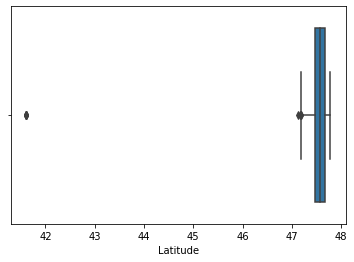

In [41]:
sns.boxplot(res_home_sales['Latitude'])

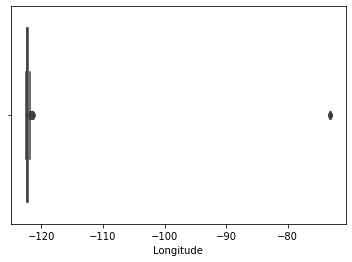

In [42]:
sns.boxplot(res_home_sales['Longitude'])

In [43]:
import folium

In [44]:
#Initiate the map centered on Seattle
seattle_map = folium.Map(location=[47.56,-122.4], zoom_start=9)

#Populate the map with markers for every 100th sample in our dataset 
i=0
for index, row in res_home_sales.iterrows():
    
    if i%100 == 0:
        if row['Longitude'] > -122.09:
            folium.Marker([row['Latitude'],row['Longitude']],
               popup = ['Lat: ' + str(row['Latitude']), 'Long: '+ str(row['Longitude']), 
                      'SalePrice: ' + str(row['SalePrice'])],
                         icon=folium.Icon(icon='cloud',icon_color='black',color='red')).add_to(seattle_map)
        else:
            folium.Marker([row['Latitude'],row['Longitude']],
           popup = ['Lat: ' + str(row['Latitude']), 'Long: '+ str(row['Longitude']), 
                  'SalePrice: ' + str(row['SalePrice'])],
                     color='blue').add_to(seattle_map)
    
    i = i + 1

seattle_map

**Let's filter out parcels that are more than about an hours commute from downtown.  Homes too far into rural areas will skew our data and introduce unneccessary outliers.**

In [45]:
res_home_sales = res_home_sales[(res_home_sales.Longitude < -122.09) 
                                & (res_home_sales.Longitude > -122.6)].reset_index()
res_home_sales.shape

(4944, 34)

# Venue Data

**Since Foursquare only allows my free account to make 5000 calls per hour, we need to split our calles into 2 batches and concatenate the resulting dataframes.  We will make a new table, `cat_dictsclean`, indexed in the same order as res_home_sales.**

In [46]:
import foursquare

###  This is our first call to foursquare, for the first 4500 venue lists.

The below gathers the responses from FourSquare and makes a dataframe where each row corresponds to the categories of the 10 closes venues within 1km.  I will make this call twice, since I'm a limited to 5000 calls per hour with my api account, and concatenate the results.  

In [48]:
cat_dict = []
for index, row in res_home_sales.iloc[:4500].iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe = json_normalize(venues)

    #nearcats will hold the venues this particular sample
    nearcats = []
    for category in dataframe['categories']:
        for thing in category:
            if thing['primary'] == True:
                    nearcats.append(thing['name'])
    #Append nearcats to the bottom of our dataframe.  This will match to the appropriate parcel when we join these with the parcel data.
    cat_dict.append(nearcats)
;
cat_dict = pd.DataFrame(cat_dict)
cat_dict.shape

(4500, 10)

In [49]:
cat_dict.to_csv(cat_dict1path,index=False)

In [50]:
cat_dict.head()

,0,1,2,3,4,5,6,7,8,9
0,Golf Course,Trail,Pizza Place,Preschool,Automotive Shop,Automotive Shop,None,None,None,None
1,Other Great Outdoors,Church,Taco Place,Mobile Phone Shop,Tattoo Parlor,Library,Non-Profit,Bank,Automotive Shop,None
2,Elementary School,Discount Store,Pharmacy,Automotive Shop,Doctor's Office,Park,Gym / Fitness Center,Insurance Office,Grocery Store,Liquor Store
3,General Entertainment,Golf Course,Residential Building (Apartment / Condo),Park,Miscellaneous Shop,Health & Beauty Service,Burger Joint,Residential Building (Apartment / Condo),Residential Building (Apartment / Condo),General Travel
4,Park,Theater,Pool,Pizza Place,School,Skating Rink,Video Store,Donut Shop,Locksmith,Pizza Place


### I have to wait an hour before making a second call, so I used time.sleep() to pause the program.

In [52]:
import time
time.sleep(4000)
cat_dict2 = []
for index, row in res_home_sales.iloc[4500:].iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    #nearcats will hold the venues this particular sample
    nearcats = []
    for category in dataframe['categories']:
        for thing in category:
            if thing['primary'] == True:
                    nearcats.append(thing['name'])
                    
    #Append nearcats to the bottom of our dataframe.  This will match to the appropriate parcel when we join these with the parcel data.
    cat_dict2.append(nearcats)
cat_dict2 = pd.DataFrame(cat_dict2)
cat_dict2.head()

,0,1,2,3,4,5,6,7,8,9
0,Lake,Real Estate Office,Pizza Place,Theater,Rugby Pitch,None,None,None,None,None
1,Bus Station,Playground,Preschool,Church,Discount Store,Martial Arts Dojo,Deli / Bodega,Food Truck,Fast Food Restaurant,Grocery Store
2,Fast Food Restaurant,Storage Facility,Movie Theater,Pizza Place,Mexican Restaurant,Automotive Shop,Pharmacy,Grocery Store,None,None
3,Elementary School,Mountain,Office,Building,Mobile Phone Shop,Office,Building,Office,Convenience Store,Automotive Shop
4,Mobile Phone Shop,Non-Profit,Wine Shop,Grocery Store,Taco Place,Pharmacy,Gas Station,Coffee Shop,Post Office,Pizza Place


In [53]:
cat_dict2.to_csv(cat_dict2path,index=False)

In [54]:
cat_dict2 = pd.read_csv(cat_dict2path)
cat_dict2

,0,1,2,3,4,5,6,7,8,9
0,Lake,Real Estate Office,Pizza Place,Theater,Rugby Pitch,NaN,NaN,NaN,NaN,NaN
1,Bus Station,Playground,Preschool,Church,Discount Store,Martial Arts Dojo,Deli / Bodega,Food Truck,Fast Food Restaurant,Grocery Store
2,Fast Food Restaurant,Storage Facility,Movie Theater,Pizza Place,Mexican Restaurant,Automotive Shop,Pharmacy,Grocery Store,NaN,NaN
3,Elementary School,Mountain,Office,Building,Mobile Phone Shop,Office,Building,Office,Convenience Store,Automotive Shop
4,Mobile Phone Shop,Non-Profit,Wine Shop,Grocery Store,Taco Place,Pharmacy,Gas Station,Coffee Shop,Post Office,Pizza Place
5,Residential Building (Apartment / Condo),Gym / Fitness Center,Bowling Alley,Grocery Store,Supermarket,Grocery Store,Pet Store,Pizza Place,Vegetarian / Vegan Restaurant,Scenic Lookout
6,Elementary School,Pub,Smoke Shop,Pizza Place,Pharmacy,Hockey Arena,Other Great Outdoors,NaN,NaN,NaN
7,Office,Dentist's Office,Police Station,Electronics Store,Coworking Space,Cafeteria,Office,Trail,Lake,Food Truck
8,Church,Library,Café,Pizza Place,Residential Building (Apartment / Condo),Organic Grocery,Dentist's Office,Church,Gym,NaN
9,Middle School,Event Space,Lake,Rental Service,Moving Target,Elementary School,Inn,Building,Fire Station,Auto Dealership


### Concatenate our lists and replace Nas with an empty string.

In [55]:
frames = [cat_dict,cat_dict2]
cleancat_dict = pd.concat(frames, axis=0,join='outer',ignore_index=True)
cleancat_dict

,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9
0,Golf Course,Trail,Pizza Place,Preschool,Automotive Shop,Automotive Shop,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Other Great Outdoors,Church,Taco Place,Mobile Phone Shop,Tattoo Parlor,Library,Non-Profit,Bank,Automotive Shop,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Elementary School,Discount Store,Pharmacy,Automotive Shop,Doctor's Office,Park,Gym / Fitness Center,Insurance Office,Grocery Store,Liquor Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,General Entertainment,Golf Course,Residential Building (Apartment / Condo),Park,Miscellaneous Shop,Health & Beauty Service,Burger Joint,Residential Building (Apartment / Condo),Residential Building (Apartment / Condo),General Travel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Park,Theater,Pool,Pizza Place,School,Skating Rink,Video Store,Donut Shop,Locksmith,Pizza Place,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trail,Doctor's Office,Gym,Historic Site,Pizza Place,Physical Therapist,Coffee Shop,Residential Building (Apartment / Condo),NaN,NaN
4940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gym,Soccer Field,Park,Dog Run,Art Gallery,Playground,Laundry Service,Laundry Service,Park,Church
4941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bus Station,Ice Cream Shop,Speakeasy,Greek Restaurant,Pharmacy,Pharmacy,Playground,Car Wash,Massage Studio,NaN
4942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other Great Outdoors,Church,Nail Salon,Gaming Cafe,Sporting Goods Shop,Convenience Store,Coffee Shop,Cosmetics Shop,NaN,NaN


# Transform lists of Venues into One-Hot Format 

### We want one column for each sample with data about how many of each venue type are in the 10 closest within 1km of the sample.

* *The value in the cell in that column for each  sample that represents the number of those kinds of venues that are nearby.  This allows our model to incorporate this information in a linear regression model later.

* *cat_dictclean shows, for each parcel, the closest 10 venues within 1km, keeping repeated categories of venues.  The index are the parcels, and the columns are the ordinality.*

* *However I want to get this into a one-hot format.  So, I'll turn this into a dataframe with each category as a column and the value of each cell as the number of venues appearing on the list with that category.  This preserves information about how many of each kind of venue are nearby.  

* *Finally, I'll drop the columns corresponding to venue categories that occur fewer than 100 times.

In [56]:
#Create a list of all of the category types to be our columns
uniquecats = pd.unique(cleancat_dict.values.ravel('K'))
#Making a blank DataFrame with each type of category as columns and the index for catdict_clean (and our sales data) as the index.
hotcats = pd.DataFrame(columns=uniquecats,index=cleancat_dict.index)
#Populate the data in the frame for how many of each venue category appeared in that sample's list of 10 closest venues.
for index, row in cleancat_dict.iterrows():
    
    for cat in range(len(row.value_counts()[:])):
        hotcats[row.value_counts().index[cat]][index] = row.value_counts()[cat]
#Fill the NaNs with 0s
cleancats = hotcats.T[hotcats.count() > 100].T.fillna(0)

cleancats.shape

(4944, 105)

**`cleancats` is now indexed by parcel the samples from the table of parcel data, and has a column for every venue category that appeared in our data more than 100 times.  This was done on the assumption that many homes clustered around a venue would all list that venue, and generally that our sample sizes for these venues would not be high enough to be statistically significant to our model.**

In [57]:
cleancats

,Golf Course,Other Great Outdoors,Elementary School,General Entertainment,Park,Mexican Restaurant,Vietnamese Restaurant,Gas Station,Housing Development,Playground,Pool,Church,Dive Bar,Convenience Store,Middle School,Grocery Store,Brewery,Bar,Salon / Barbershop,Residential Building (Apartment / Condo),Post Office,Beach,Lake,Medical Center,Sandwich Place,Nail Salon,Pizza Place,Moving Target,Building,Preschool,Library,Trail,Farm,Community Center,High School,Gym / Fitness Center,Bridge,Gym,Supermarket,School,Dance Studio,Athletics & Sports,Garden,Airport,Beer Bar,Dog Run,Pharmacy,Scenic Lookout,Bank,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Doctor's Office,Pub,Coffee Shop,Food Truck,Hardware Store,Bus Stop,Field,Laundry Service,Dentist's Office,Bus Station,Auto Dealership,Veterinarian,Tennis Court,Chinese Restaurant,Furniture / Home Store,Bus Line,Café,Event Space,Italian Restaurant,Marijuana Dispensary,Office,Yoga Studio,Restaurant,Baseball Field,Discount Store,Physical Therapist,American Restaurant,Martial Arts Dojo,Spa,Storage Facility,Daycare,General Travel,Burger Joint,Pet Service,Thai Restaurant,Chiropractor,Bakery,Mobile Phone Shop,Ice Cream Shop,Automotive Shop,Assisted Living,Health & Beauty Service,Fried Chicken Joint,Taco Place,Video Store,Financial or Legal Service,Massage Studio,Asian Restaurant,Insurance Office,Japanese Restaurant,ATM,Locksmith,Shipping Store
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4940,0,0,0,0,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4941,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4942,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
cleancats.to_csv(cleancatspath,index=False)

# Finishing Touches
* **Finally, we will:**
* Concatenate our sales data and our one-hot category columns
* put the remaining category variables into a one-hot format

### Dropping Features

**I'm joining the category features and the home features, and dropping some features before saving our dataframe.**

* I'm dropping BldgGradeVar because it's redundant with BldgGrade.  
* I'm droping PIN because we just needed that to match sales and parcel data.  We don't want our model considering it.
* I'm dropping Stories because it's information strongly overlaps with the square footage measures of each floor.  e.g. if SqFt2ndFloor = 0, then Stories < 2.  We have the information we need about height of houses without this column.
* I'm dropping ViewUtilization because in later modeling it never seemed to correlate strongly with SalePrice.  
* I'm dropping the "Residential Building" venue, because this is not really the kind of 'venue' we are talking about in this project.

In [59]:
#Join our venue category data to our home sales data.
seattle_home_sales = res_home_sales.join(cleancats)

#drop features we non longer need
seattle_home_sales.drop(['BldgGradeVar','PIN','Stories','Address','ViewUtilization','Residential Building (Apartment / Condo)'], axis=1, inplace = True)
seattle_home_sales.head(50)

,SalePrice,YearSold,MonthSold,BldgGrade,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,PcntComplete,Condition,Longitude,Latitude,Golf Course,Other Great Outdoors,Elementary School,General Entertainment,Park,Mexican Restaurant,Vietnamese Restaurant,Gas Station,Housing Development,Playground,Pool,Church,Dive Bar,Convenience Store,Middle School,Grocery Store,Brewery,Bar,Salon / Barbershop,Post Office,Beach,Lake,Medical Center,Sandwich Place,Nail Salon,Pizza Place,Moving Target,Building,Preschool,Library,Trail,Farm,Community Center,High School,Gym / Fitness Center,Bridge,Gym,Supermarket,School,Dance Studio,Athletics & Sports,Garden,Airport,Beer Bar,Dog Run,Pharmacy,Scenic Lookout,Bank,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Doctor's Office,Pub,Coffee Shop,Food Truck,Hardware Store,Bus Stop,Field,Laundry Service,Dentist's Office,Bus Station,Auto Dealership,Veterinarian,Tennis Court,Chinese Restaurant,Furniture / Home Store,Bus Line,Café,Event Space,Italian Restaurant,Marijuana Dispensary,Office,Yoga Studio,Restaurant,Baseball Field,Discount Store,Physical Therapist,American Restaurant,Martial Arts Dojo,Spa,Storage Facility,Daycare,General Travel,Burger Joint,Pet Service,Thai Restaurant,Chiropractor,Bakery,Mobile Phone Shop,Ice Cream Shop,Automotive Shop,Assisted Living,Health & Beauty Service,Fried Chicken Joint,Taco Place,Video Store,Financial or Legal Service,Massage Studio,Asian Restaurant,Insurance Office,Japanese Restaurant,ATM,Locksmith,Shipping Store
0,400000,2017,04,8,1590,0,0,0,3180,1590,1590,7,0,600,Y,50,0,220,5,0,6,0,2,1,1965,0,4,-122.196399,47.336118,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1,474250,2018,03,7,1390,0,0,0,2200,810,810,7,0,0,Y,0,0,340,5,0,4,1,0,1,1945,0,3,-122.361913,47.509874,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,667950,2019,03,8,1010,0,1515,0,2525,0,0,0,0,400,N,167,0,0,5,0,4,1,0,2,2019,0,3,-122.156684,47.437557,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,659000,2017,09,9,660,0,540,0,1820,620,620,9,0,0,Y,0,0,100,6,0,3,1,0,2,2016,0,3,-122.370252,47.565146,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,656500,2017,10,7,2310,0,0,0,2310,0,0,0,0,440,N,40,0,320,5,0,3,0,0,2,1967,0,3,-122.184194,47.730389,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
5,675000,2018,10,7,1330,0,0,0,1970,1310,640,7,530,0,Y,0,0,150,5,0,4,1,1,1,1965,0,3,-122.115736,47.628829,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,415000,2016,06,8,1420,0,0,0,1750,1370,330,7,530,0,Y,0,0,390,5,0,3,0,1,1,1960,0,3,-122.251946,47.771614,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,160000,2016,10,7,1020,410,0,0,1430,1020,0,0,0,0,,190,0,0,6,0,4,0,0,1,1922,0,3,-12

**Next we have some other category variabes that need to be turned into one-hot format, as well.**

With our dataset we need to be particularly concerned with multicollinearity.  One way to reduce this in One-Hot formats is to drop one column.  If `condition_2` through `condition_5` are `0`, then we know that `condition_1` is 1.  This doesn't work with our venues because none are derivable from any combination of others.  So we will drop the first column of each of our sets of one-hot features.

In [60]:
#Turn these category variables into one-hot format
OneHots = pd.get_dummies(seattle_home_sales['BldgGrade'],prefix='BldgGrade')
OneHots =OneHots.join(pd.get_dummies(seattle_home_sales['FinBasementGrade'],prefix = 'FinBasementGrade'),how = 'inner')
OneHots =OneHots.join(pd.get_dummies(seattle_home_sales['HeatSystem'],prefix = 'HeatSystem'),how = 'inner')
OneHots =OneHots.join(pd.get_dummies(seattle_home_sales['Condition'],prefix = 'Condition'),how= 'inner')
OneHots =OneHots.join(pd.get_dummies(seattle_home_sales['MonthSold'],prefix = 'MonthSold'),how= 'inner')
OneHots =OneHots.join(pd.get_dummies(seattle_home_sales['YearSold'],prefix = 'YearSold'),how= 'inner')


#Join it to seattle_home_sales
seattle_home_sales = seattle_home_sales.join(OneHots,how='inner')
seattle_home_sales = seattle_home_sales.drop(columns=['BldgGrade','FinBasementGrade','YearSold','HeatSystem','Condition','MonthSold','BldgGrade_3','FinBasementGrade_0','HeatSystem_0','Condition_1','MonthSold_01','YearSold_2016'])

seattle_home_sales

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,PcntComplete,Longitude,Latitude,Golf Course,Other Great Outdoors,Elementary School,General Entertainment,Park,Mexican Restaurant,Vietnamese Restaurant,Gas Station,Housing Development,Playground,Pool,Church,Dive Bar,Convenience Store,Middle School,Grocery Store,Brewery,Bar,Salon / Barbershop,Post Office,Beach,Lake,Medical Center,Sandwich Place,Nail Salon,Pizza Place,Moving Target,Building,Preschool,Library,Trail,Farm,Community Center,High School,Gym / Fitness Center,Bridge,Gym,Supermarket,School,Dance Studio,Athletics & Sports,Garden,Airport,Beer Bar,Dog Run,Pharmacy,Scenic Lookout,Bank,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Doctor's Office,Pub,Coffee Shop,Food Truck,Hardware Store,Bus Stop,Field,Laundry Service,Dentist's Office,Bus Station,Auto Dealership,Veterinarian,Tennis Court,Chinese Restaurant,Furniture / Home Store,Bus Line,Café,Event Space,Italian Restaurant,Marijuana Dispensary,Office,Yoga Studio,Restaurant,Baseball Field,Discount Store,Physical Therapist,American Restaurant,Martial Arts Dojo,Spa,Storage Facility,Daycare,General Travel,Burger Joint,Pet Service,Thai Restaurant,Chiropractor,Bakery,Mobile Phone Shop,Ice Cream Shop,Automotive Shop,Assisted Living,Health & Beauty Service,Fried Chicken Joint,Taco Place,Video Store,Financial or Legal Service,Massage Studio,Asian Restaurant,Insurance Office,Japanese Restaurant,ATM,Locksmith,Shipping Store,BldgGrade_4,BldgGrade_5,BldgGrade_6,BldgGrade_7,BldgGrade_8,BldgGrade_9,BldgGrade_10,BldgGrade_11,BldgGrade_12,FinBasementGrade_3,FinBasementGrade_4,FinBasementGrade_5,FinBasementGrade_6,FinBasementGrade_7,FinBasementGrade_8,FinBasementGrade_9,FinBasementGrade_10,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8,Condition_2,Condition_3,Condition_4,Condition_5,MonthSold_02,MonthSold_03,MonthSold_04,MonthSold_05,MonthSold_06,MonthSold_07,MonthSold_08,MonthSold_09,MonthSold_10,MonthSold_11,MonthSold_12,YearSold_2017,YearSold_2018,YearSold_2019,YearSold_2020
0,400000,1590,0,0,0,3180,1590,1590,0,600,Y,50,0,220,0,6,0,2,1,1965,0,-122.196399,47.336118,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,474250,1390,0,0,0,2200,810,810,0,0,Y,0,0,340,0,4,1,0,1,1945,0,-122.361913,47.509874,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,667950,1010,0,1515,0,2525,0,0,0,400,N,167,0,0,0,4,1,0,2,2019,0,-122.156684,47.437557,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,659000,660,0,540,0,1820,620,620,0,0,Y,0,0,100,0,3,1,0,2,2016,0,-122.370252,47.565146,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,656500,2310,0,0,0,2310,0,0,0,440,N,40,0,320,0,3,0,0,2,1967,0,-122.184194,47.730389,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

In [61]:
#Let's make sure all of our columns are numbers so our model can analyze them.

seattle_home_sales.dtypes

SalePrice                       int64
SqFt1stFloor                    int64
SqFtHalfFloor                   int64
SqFt2ndFloor                    int64
SqFtUpperFloor                  int64
SqFtTotLiving                   int64
SqFtTotBasement                 int64
SqFtFinBasement                 int64
SqFtGarageBasement              int64
SqFtGarageAttached              int64
DaylightBasement               object
SqFtOpenPorch                   int64
SqFtEnclosedPorch               int64
SqFtDeck                        int64
BrickStone                      int64
Bedrooms                        int64
BathHalfCount                   int64
Bath3qtrCount                   int64
BathFullCount                   int64
YrBuilt                         int64
PcntComplete                    int64
Longitude                     float64
Latitude                      float64
Golf Course                     int64
Other Great Outdoors            int64
Elementary School               int64
General Ente

*We will replace 'Y' and 'N' in DaylightBasement with '1' and '0'.  I assume missing values do not have daylight basements, so I will fill those will '0's.*

In [62]:
seattle_home_sales = seattle_home_sales.replace(['Y','N',' '],[1,0,0])

In [63]:
seattle_home_sales.to_csv(Finalpath,index=False)

## We now have a nice clean dataset with data about the home sales and nearby venues in an analysis friendly format.  We are ready to do some analysis.